In [26]:
import os
from glob import glob
import re
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from cv2.dnn import NMSBoxes as non_max_suppression
import time  

In [27]:
data_path = 'cv_dataset/cv_dataset'
all_files = os.listdir(data_path)
png_files = [file for file in all_files if file.endswith('.png')]
sorted_png_files = sorted(png_files)
image_paths = [os.path.join(data_path, file) for file in sorted_png_files]
print(len(image_paths))

95


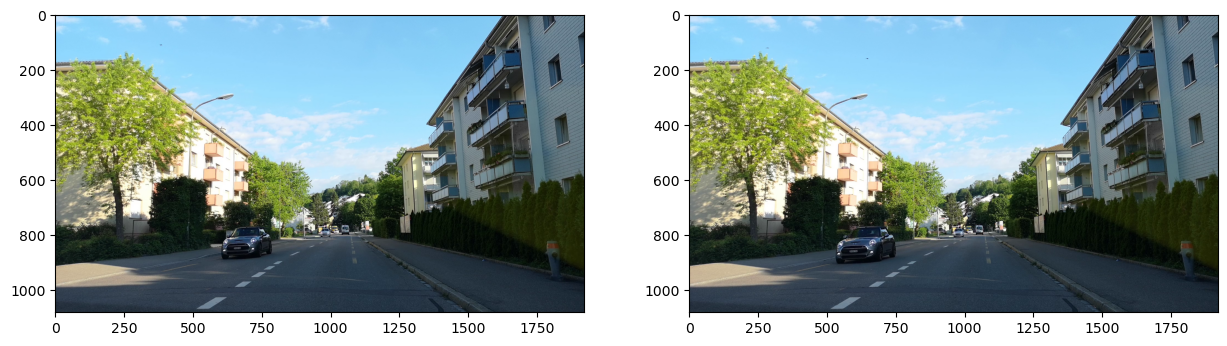

In [28]:
idx = 15
frame1_bgr = cv2.imread(image_paths[idx])
frame2_bgr = cv2.imread(image_paths[idx+1])
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].imshow(cv2.cvtColor(frame1_bgr, cv2.COLOR_BGR2RGB))
ax[1].imshow(cv2.cvtColor(frame2_bgr, cv2.COLOR_BGR2RGB));

In [29]:
def compute_flow(frame1, frame2):
    # convert to grayscale
    gray1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
    gray1 = cv2.GaussianBlur(gray1, dst=None, ksize=(3,3), sigmaX=5)
    gray2 = cv2.GaussianBlur(gray2, dst=None, ksize=(3,3), sigmaX=5)

    flow = cv2.calcOpticalFlowFarneback(gray1, gray2, None,
                                        pyr_scale=0.75,
                                        levels=3,
                                        winsize=5,
                                        iterations=3,
                                        poly_n=10,
                                        poly_sigma=1.2,
                                        flags=0)
    return flow


def get_flow_viz(flow):

    hsv = np.zeros((flow.shape[0], flow.shape[1], 3), dtype=np.uint8)
    hsv[..., 1] = 255

    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hsv[..., 0] = ang*180/np.pi/2
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

    return rgb

C:\Users\shripad\AppData\Local\Temp\ipykernel_20052\3542669749.py:15: RuntimeWarning: divide by zero encountered in log
  ax[2].imshow(np.log(mag/mag.max()), cmap='hsv_r') # try other cmaps 'hsv_r', 'gist_earth_r', 'rainbow_r', 'twilight_r'


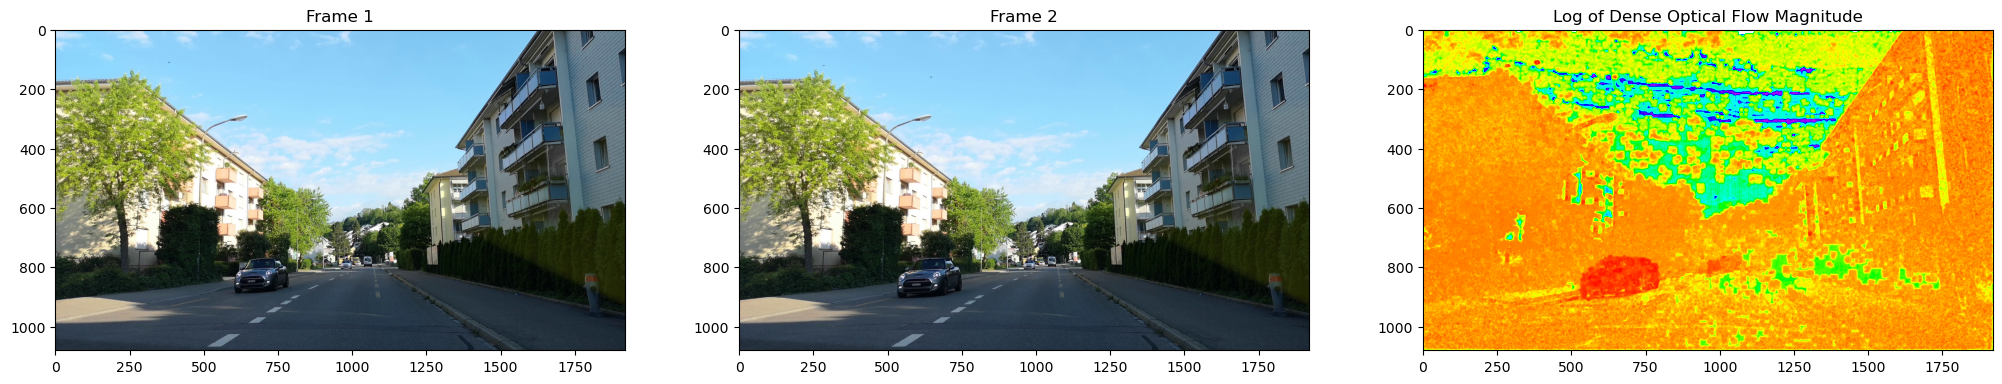

In [30]:
flow = compute_flow(frame1_bgr, frame2_bgr)

mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])


img1_rgb = cv2.cvtColor(frame1_bgr, cv2.COLOR_BGR2RGB)
img2_rgb = cv2.cvtColor(frame2_bgr, cv2.COLOR_BGR2RGB)


fig, ax = plt.subplots(1, 3, figsize=(25, 25))
ax[0].imshow(img1_rgb)
ax[0].set_title('Frame 1')
ax[1].imshow(img2_rgb)
ax[1].set_title('Frame 2')
ax[2].imshow(np.log(mag/mag.max()), cmap='hsv_r') # try other cmaps 'hsv_r', 'gist_earth_r', 'rainbow_r', 'twilight_r'
ax[2].set_title('Log of Dense Optical Flow Magnitude');

In [31]:
def get_motion_mask(flow_mag, motion_thresh=1, kernel=np.ones((7,7))):
    motion_mask = np.uint8(flow_mag > motion_thresh)*255
    motion_mask = cv2.erode(motion_mask, kernel, iterations=1)
    motion_mask = cv2.morphologyEx(motion_mask, cv2.MORPH_OPEN, kernel, iterations=1)
    motion_mask = cv2.morphologyEx(motion_mask, cv2.MORPH_CLOSE, kernel, iterations=3)
    return motion_mask

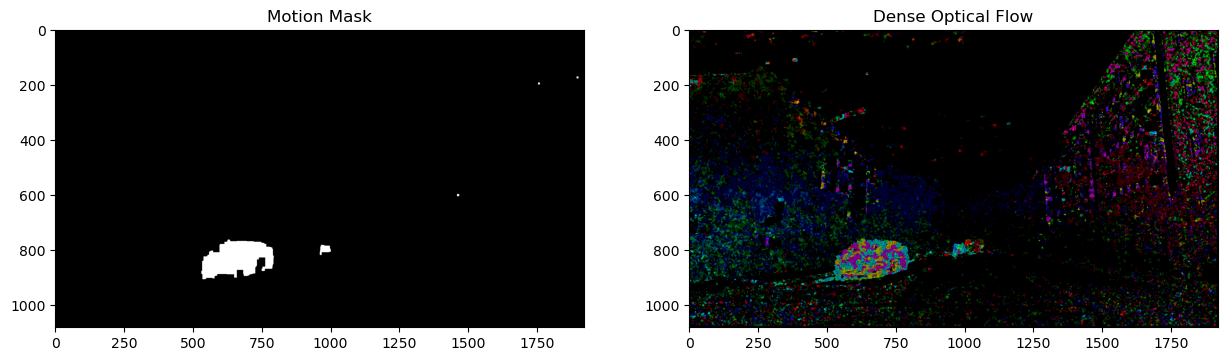

In [32]:
rgb = get_flow_viz(flow)
motion_thresh = np.c_[np.linspace(0.3, 1, 1080)].repeat(1920, axis=-1)

mask = get_motion_mask(mag, motion_thresh=motion_thresh)

fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].imshow(mask, cmap='gray')
ax[0].set_title("Motion Mask")
ax[1].imshow(rgb*50) # scale RGB to see the noise
ax[1].set_title("Dense Optical Flow");

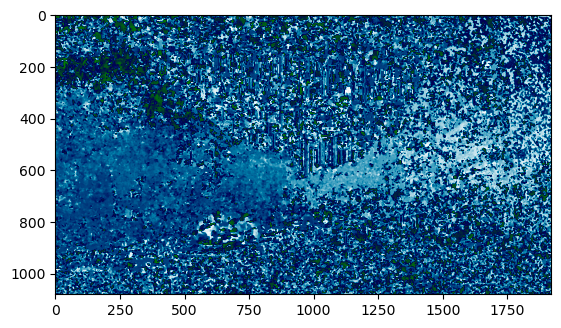

In [33]:
plt.imshow(ang, cmap='ocean') 

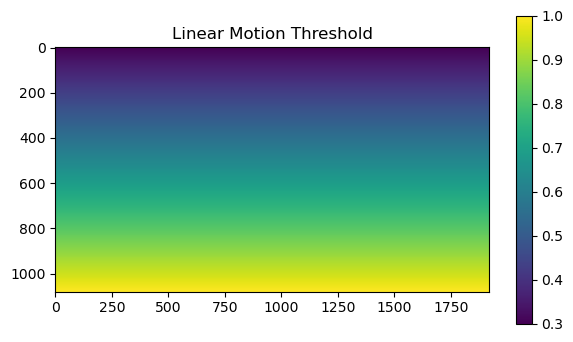

In [34]:
plt.figure(figsize=(7,4))
plt.imshow(motion_thresh)
plt.title("Linear Motion Threshold");
plt.colorbar();

In [35]:
def get_contour_detections_2(mask, ang=ang, angle_thresh=2, thresh=400):
    contours, _ = cv2.findContours(mask, 
                                   cv2.RETR_EXTERNAL, 
                                   cv2.CHAIN_APPROX_TC89_L1)
    temp_mask = np.zeros_like(mask) 
    angle_thresh = angle_thresh*ang.std()
    detections = []
    for cnt in contours:
        
        x,y,w,h = cv2.boundingRect(cnt)
        area = w*h

       
        cv2.drawContours(temp_mask, [cnt], 0, (255,), -1)
        flow_angle = ang[np.nonzero(temp_mask)]

        if (area > thresh) and (flow_angle.std() < angle_thresh): 
            detections.append([x,y,x+w,y+h, area])

    return np.array(detections)

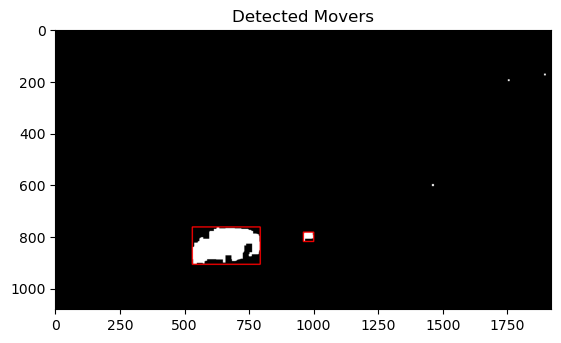

In [36]:
mask_rgb = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
detections = get_contour_detections_2(mask, ang, angle_thresh=2, thresh=400)

bboxes = detections[:, :4]
scores = detections[:, -1]

for box in bboxes:
    x1,y1,x2,y2 = box
    cv2.rectangle(mask_rgb, (x1,y1), (x2,y2), (255,0,0), 3)

plt.imshow(mask_rgb)
plt.title("Detected Movers");

In [37]:
def remove_contained_bboxes(boxes):
    
    check_array = np.array([True, True, False, False])
    keep = list(range(0, len(boxes)))
    for i in keep: # range(0, len(bboxes)):
        for j in range(0, len(boxes)):
           
            if np.all((np.array(boxes[j]) >= np.array(boxes[i])) == check_array):
                try:
                    keep.remove(j)
                except ValueError:
                    continue
    return keep

In [38]:
def non_max_suppression(boxes, scores, threshold=1e-1):
    
    
    boxes = boxes[np.argsort(scores)[::-1]]

   
    order = remove_contained_bboxes(boxes)

    keep = []
    while order:
        i = order.pop(0)
        keep.append(i)
        for j in order:
           
            intersection = max(0, min(boxes[i][2], boxes[j][2]) - max(boxes[i][0], boxes[j][0])) * \
                           max(0, min(boxes[i][3], boxes[j][3]) - max(boxes[i][1], boxes[j][1]))
            union = (boxes[i][2] - boxes[i][0]) * (boxes[i][3] - boxes[i][1]) + \
                    (boxes[j][2] - boxes[j][0]) * (boxes[j][3] - boxes[j][1]) - intersection
            iou = intersection / union

            
            if iou > threshold:
                order.remove(j)
                
    return boxes[keep]

In [39]:
nms_bboxes = non_max_suppression(bboxes, scores, threshold=0.1)
len(bboxes), len(nms_bboxes)

(2, 2)

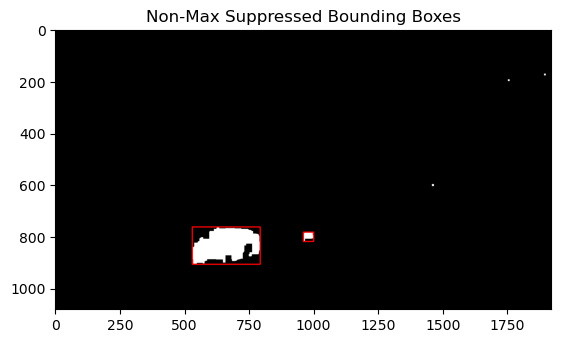

In [40]:
mask_rgb_detections = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
for det in nms_bboxes:
    x1, y1, x2, y2 = det
    cv2.rectangle(mask_rgb_detections, (x1,y1), (x2,y2), (255,0,0), 3)

plt.imshow(mask_rgb_detections)
plt.title("Non-Max Suppressed Bounding Boxes");

In [41]:
def draw_bboxes(frame, detections):
    for det in detections:
        x1,y1,x2,y2 = det
        cv2.rectangle(frame, (x1,y1), (x2,y2), (0,255,0), 3)

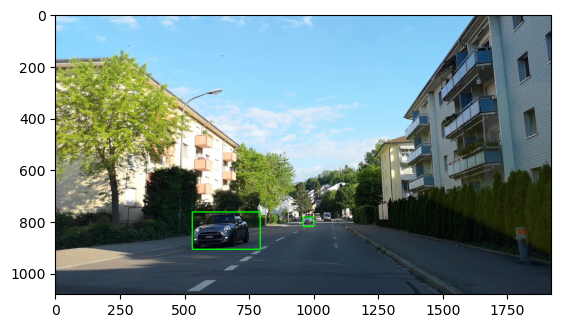

In [42]:
frame2 = img2_rgb.copy()
draw_bboxes(frame2, nms_bboxes)
plt.imshow(frame2);

In [43]:
def get_contour_detections(mask, thresh=400):
    
    contours, _ = cv2.findContours(mask, 
                                   cv2.RETR_EXTERNAL, 
                                   cv2.CHAIN_APPROX_TC89_L1)
    detections = []
    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)
        area = w*h
        if area > thresh: 
            detections.append([x,y,x+w,y+h, area])

    return np.array(detections)


In [44]:
def get_detections(frame1, frame2, motion_thresh=1, bbox_thresh=400, nms_thresh=0.1, mask_kernel=np.ones((7,7), dtype=np.uint8)):
    
    flow = compute_flow(frame1, frame2)

    
    mag, _ = cv2.cartToPolar(flow[..., 0], flow[..., 1])

    motion_mask = get_motion_mask(mag, motion_thresh=motion_thresh, kernel=mask_kernel)

    
    detections = get_contour_detections(motion_mask, bbox_thresh)

    
    bboxes = detections[:, :4]
    scores = detections[:, -1]

    
    return non_max_suppression(bboxes, scores, threshold=nms_thresh)
    

In [20]:
import cv2
import os

video_frames = []


motion_thresh = np.c_[np.linspace(0.3, 1, 1080)].repeat(1920, axis=-1)
kernel = np.ones((7,7), dtype=np.uint8)

for idx in range(1, len(image_paths)):
    
    frame1_bgr = cv2.imread(image_paths[idx - 1])
    frame2_bgr = cv2.imread(image_paths[idx])


    detections = get_detections(frame1_bgr, 
                                frame2_bgr, 
                                motion_thresh=motion_thresh, 
                                bbox_thresh=400, 
                                nms_thresh=0.1, 
                                mask_kernel=kernel)
                                
   
    draw_bboxes(frame2_bgr, detections)

    
    video_frames.append(frame2_bgr)

output_video_file = 'cv_project_1_1.mp4'


if video_frames:
    
    height, width, _ = video_frames[0].shape  

   
    fourcc = cv2.VideoWriter_fourcc(*'mp4v') 
    fps = 5  
    output_video_path = os.path.join( output_video_file)
    video_writer = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

   
    for frame in video_frames:
        video_writer.write(frame)

    
    video_writer.release()

    print("Video saved successfully as MP4 at:", output_video_path)
else:
    print("No frames found to create video.")

Video saved successfully as MP4 at: output_videoo.mp4


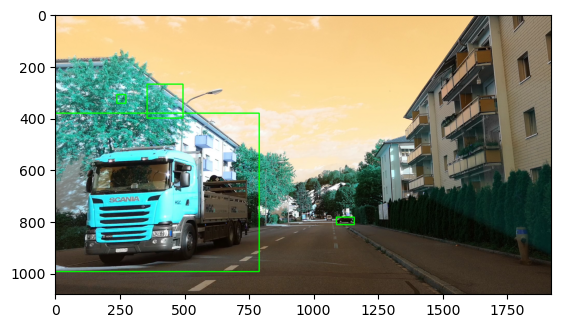

In [21]:
plt.imshow(frame2_bgr)